<a href="https://colab.research.google.com/github/Camillabgarcia/agrupamento_facial/blob/main/agrupamento_por_semelhan%C3%A7a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install deepface gitpython opencv-python-headless tqdm pillow scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=fc9f6dbc70266a763ad28e7a76cdf079f7b8e3e96d46f44bb1bcdb35d68b1139
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [11]:
import os
import numpy as np
import git
from deepface import DeepFace
import cv2
from PIL import Image, ImageEnhance
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [13]:
# Função para clonar o repositório
def clonar_repositorio(url, caminho):
    if not os.path.exists(caminho):
        git.Repo.clone_from(url, caminho)
        print('O repositório foi clonado com sucesso.')
    else:
        print('O repositório já existe.')

In [14]:
# Função para carregamento e melhoria das imagens
def upload_imagem(diretorio):
    imagens = []
    for subdir, _, files in os.walk(diretorio):
        for nome in files:
            caminho_imagem = os.path.join(subdir, nome)
            if os.path.isfile(caminho_imagem) and nome.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                imagem = Image.open(caminho_imagem).convert('RGB')
                imagem = imagem.resize((250, 250))
                contraste = ImageEnhance.Contrast(imagem)
                imagem = contraste.enhance(2.0)
                imagem_np = np.array(imagem)
                imagens.append(imagem_np)
    return imagens

In [15]:
# Função para gerar embeddings usando o DeepFace
def gerar_embeddings(imagens):
    embeddings = []
    for imagem in imagens:
        try:
            embedding = DeepFace.represent(img_path=imagem, model_name='Facenet', enforce_detection=False)[0]['embedding']
            embeddings.append(embedding)
        except Exception as e:
            print(f'Não foi possível processar a imagem: {e}')
    return np.array(embeddings)

In [16]:
# Função para agrupar embeddings usando KMeans com 10 clusters
def agrupar_embeddings_kmeans(embeddings, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    grupos = kmeans.fit_predict(embeddings)
    return grupos

In [17]:
# Função que reorganiza os grupos garatindo que os 10 tenham 4 imagens cada
def reorganizar_grupos(imagens, embeddings, grupos, n_grupos=10, tamanho_grupo=4, limite_similaridade=0.85):
    grupos_final = []
    unicos, contagem = np.unique(grupos, return_counts=True)

    for grupo_id in unicos:
        indices = [i for i, g in enumerate(grupos) if g == grupo_id]
        grupo_embeddings = embeddings[indices]

        matriz_similaridade = cosine_similarity(grupo_embeddings)
        np.fill_diagonal(matriz_similaridade, 0)
        similares = np.argsort(-matriz_similaridade.sum(axis=0))[:tamanho_grupo]
        subgrupo = [indices[i] for i in similares]

        grupos_final.append(subgrupo)

    todos_indices = list(range(len(imagens)))
    if len(grupos_final) < n_grupos:
        while len(grupos_final) < n_grupos:
            candidatos = [i for i in todos_indices if i not in np.concatenate(grupos_final)] if grupos_final else todos_indices
            if len(candidatos) >= tamanho_grupo:
                grupos_final.append(candidatos[:tamanho_grupo])
            else:
                break

    return grupos_final

In [18]:
# Função para visualização dos grupos
def visualizacao_grupos_filtrados(imagens, grupos_filtrados):
    for i, grupo in enumerate(grupos_filtrados):
        plt.figure(figsize=(10, 2.5))
        plt.suptitle(f'Grupo {i}', fontsize=16, fontweight='bold')
        for j, idx in enumerate(grupo):
            plt.subplot(1, 4, j + 1)
            plt.imshow(imagens[idx])
            plt.axis('off')
            plt.title(f'Imagem {j + 1}')
        plt.show()

O repositório já existe.


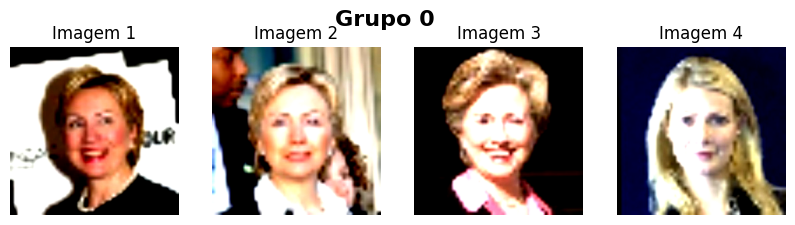

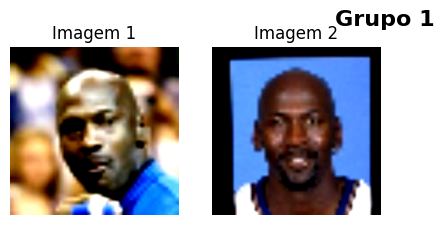

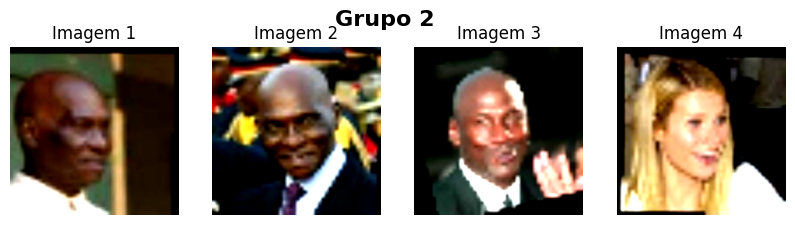

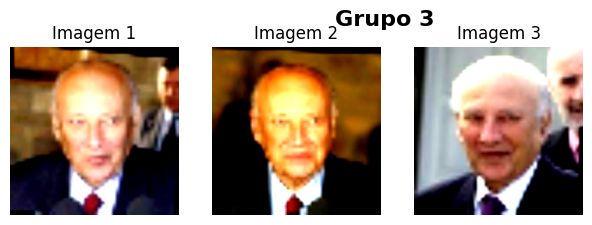

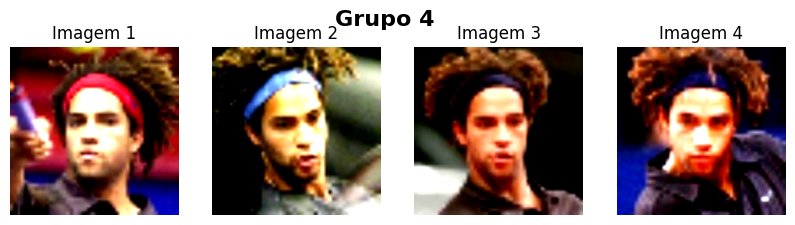

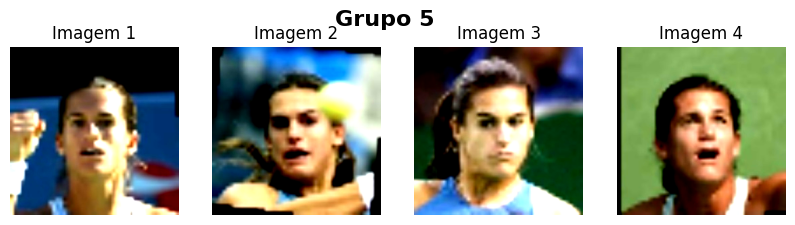

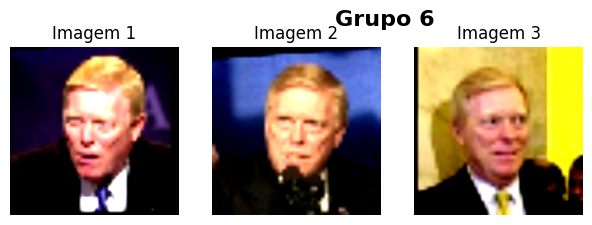

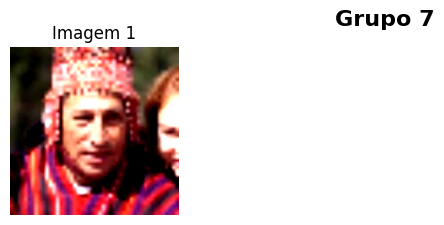

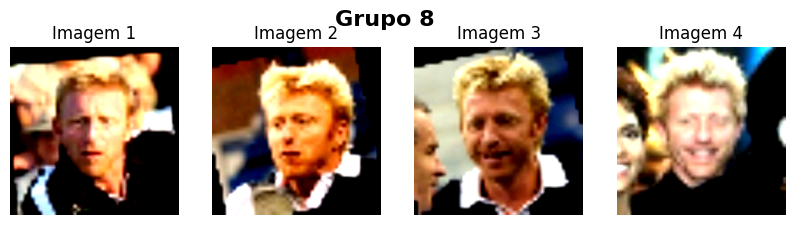

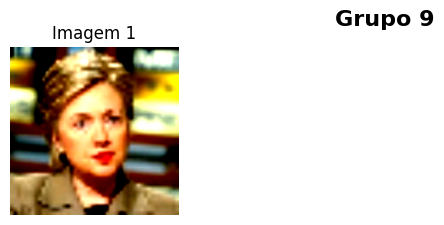

In [20]:
# Pipeline
clonar_repositorio(url_repositorio, diretorio)
imagens = upload_imagem(diretorio)
embeddings = gerar_embeddings(imagens)

# Agrupamento com KMeans
grupos = agrupar_embeddings_kmeans(embeddings, n_clusters=10)

# Reorganização dos grupos para que os 10 tenham 4 imagens similares
grupos_reorganizados = reorganizar_grupos(imagens, embeddings, grupos)

# Visualização final dos grupos
visualizacao_grupos_filtrados(imagens, grupos_reorganizados)